In [2]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from training.losses import *
from training.train import *
from training.plots import *
from models.gan import *
from models.classifier import *
from training.data import *

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999

In [4]:
data = FacesDataset("./../data/vgg_data/", transform=lambda x: (torch.tensor(transform.resize(np.array(x['image']), (48, 48))).permute((2, 0, 1)), x['class']))
train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

./../data/vgg_data/Nelly\757.jpg
./../data/vgg_data/Andrew_Buchan\295.jpg
./../data/vgg_data/Thad_Luckinbill\405.jpg
./../data/vgg_data/Bingbing_Fan\794.jpg


In [5]:
for batch in train_data:
    print(0)
    print(batch)
    print(batch[0].shape)
    break

0
[tensor([[[[3.0200e-01, 2.5936e-01, 2.4710e-01,  ..., 5.8125e-01,
           6.1569e-01, 5.9604e-01],
          [2.5935e-01, 2.3959e-01, 2.3170e-01,  ..., 5.7349e-01,
           6.0405e-01, 5.9608e-01],
          [2.1658e-01, 2.0834e-01, 2.0807e-01,  ..., 5.7648e-01,
           5.8856e-01, 5.9608e-01],
          ...,
          [4.7647e-01, 4.8437e-01, 5.0468e-01,  ..., 5.0960e-01,
           5.0217e-01, 5.0217e-01],
          [5.6123e-01, 5.5012e-01, 4.9752e-01,  ..., 5.1373e-01,
           5.0993e-01, 5.1009e-01],
          [5.9224e-01, 5.8484e-01, 5.1046e-01,  ..., 5.2181e-01,
           5.2157e-01, 5.2949e-01]],

         [[1.1769e-01, 7.8922e-02, 7.4306e-02,  ..., 6.0747e-01,
           5.8836e-01, 6.0788e-01],
          [8.6560e-02, 7.0715e-02, 6.3066e-02,  ..., 5.8868e-01,
           5.9204e-01, 6.0392e-01],
          [7.0833e-02, 5.5310e-02, 5.4913e-02,  ..., 5.6573e-01,
           5.9227e-01, 5.9608e-01],
          ...,
          [3.3530e-01, 3.4319e-01, 3.5194e-01,  ..., 4.7

In [6]:
base_classifier = SimpleClassifier(in_channels=3, image_size=48)

In [7]:
optimizer = torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS)
criterion = nn.CrossEntropyLoss()

In [10]:
base_classifier_trainer = BaseClassifierTrainer(base_classifier, criterion, optimizer, 'cpu', num_classes=51)

TypeError: __init__() got an unexpected keyword argument 'num_classes'

In [9]:
base_res = base_classifier_trainer.train(train_data, 10)

IndexError: Target 25 is out of bounds.

In [15]:
# data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0))
# train_data = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, drop_last=True)

In [9]:
generator_model = Generator(in_channels=3, out_channels=3)
discriminator_model = Discriminator(in_channels=3)
attacked_model = base_classifier.eval()

In [10]:
generator_optimizer = torch.optim.Adam(generator_model.parameters(), lr=LR, betas=BETAS)
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=LR, betas=BETAS)

In [11]:
trainer = Trainer(generator_model, discriminator_model, attacked_model,
                  GANLoss(BATCH_SIZE, 'cpu'),
                  AttackLoss(attacked_model, BATCH_SIZE, 'cpu'),
                  discriminator_optimizer, generator_optimizer, 'cpu')

In [12]:
res = trainer.train(train_data, 10)

Epoch: 0, Generator loss: 0.6318327747777696, Discriminator loss: 1.292613765216609, ResNet loss: 0.28326572937324707,
Epoch: 1, Generator loss: 0.6809492814908469, Discriminator loss: 1.23073195518376, ResNet loss: 0.0372972898267308,
Epoch: 2, Generator loss: 0.6974325096029542, Discriminator loss: 1.2092793754544027, ResNet loss: 0.023362604056029593,
Epoch: 3, Generator loss: 0.7010596294760179, Discriminator loss: 1.1964440235482439, ResNet loss: 0.01760801452207933,
Epoch: 4, Generator loss: 0.7017352665048339, Discriminator loss: 1.184214350410495, ResNet loss: 0.013758893063218059,
Epoch: 5, Generator loss: 0.7023214156932243, Discriminator loss: 1.1742363117865005, ResNet loss: 0.011416140236042538,


KeyboardInterrupt: 

In [25]:
val_batch = iter(train_data).next()[0].float()
for i in range(16):
    print(F.softmax(attacked_model(val_batch), -1).cpu().detach().numpy()[i, 0], F.softmax(attacked_model(val_batch + generator_model(val_batch)), -1).cpu().detach().numpy()[i, 0])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x2304 and 100x51)

Text(0.5, 1.0, 'Fake: Prediction: 0, confidence: 0.9990413784980774')

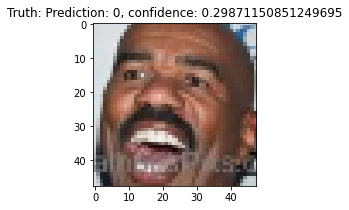

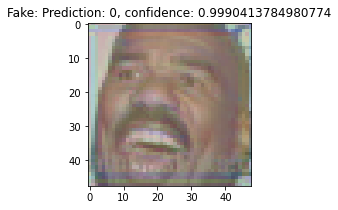

In [26]:
test_img = val_batch[15:16]
#true_confs = F.softmax(attacked_model(test_img), -1).cpu().detach().numpy()[0]
#fake_confs = F.softmax(attacked_model(test_img + generator_model(test_img)), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0].permute((1, 2, 0)), cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow(((test_img + generator_model(test_img).cpu().detach().numpy()) / 2)[0].permute((1, 2, 0)), cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(res[0],label="Generator loss")
plt.plot(res[1],label="Discriminator loss")
plt.plot(res[2],label="Attack loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()